In [ ]:
# Install all required packages
%pip install pandas numpy scikit-learn nltk joblib matplotlib

In [ ]:
# Import all the libraries we need for data processing, machine learning, and evaluation
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fhjib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load your training data from CSV (make sure 'text' and 'label' columns exist)
df = pd.read_csv('Data/train_data.csv')
if ('text' not in df.columns) or ('label' not in df.columns):
    cols = list(df.columns)
    if len(cols) >= 2:
        df = df.rename(columns={cols[0]: 'text', cols[1]: 'label'})
df = df.dropna(subset=['text', 'label']).reset_index(drop=True)
df.head()

,text,label
0,"This film is absolutely awful, but nevertheles...",0
1,Well since seeing part's 1 through 3 I can hon...,0
2,I got to see this film at a preview and was da...,1
3,This adaptation positively butchers a classic ...,0
4,Råzone is an awful movie! It is so simple. It ...,0


In [ ]:
# Clean and preprocess the text: lowercase, remove HTML, numbers, punctuation, and stopwords
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

In [6]:
# Turn text into TF-IDF features and split into train/test sets
df['clean_text'] = df['text'].apply(clean_text)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df[['clean_text','label']].head()

,clean_text,label
0,spoilers spoilers released considered quite ra...,1
1,must embarrassment every member entirely afric...,0
2,never viewed film like old time veteran actors...,1
3,two stars iconic heroesvillains know got good ...,1
4,first michael vartan movie ive seeni havent se...,1


In [ ]:
# Vectorize the cleaned text and set up the model and grid search
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])
y_train = train_df['label']
y_test = test_df['label']

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')

In [ ]:
# Fit the model using grid search and find the best parameters
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
grid = GridSearchCV(LogisticRegression(max_iter=300, random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
model = grid.best_estimator_
model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,300
,multi_class,'deprecated'


In [9]:
# Evaluate the model on the test set and print accuracy, precision, recall, and F1-score
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy  : {acc:.4f}')
print(f'Precision : {prec:.4f}')
print(f'Recall    : {rec:.4f}')
print(f'F1-score  : {f1:.4f}')

Accuracy  : 0.8864
Precision : 0.8864
Recall    : 0.8864
F1-score  : 0.8864


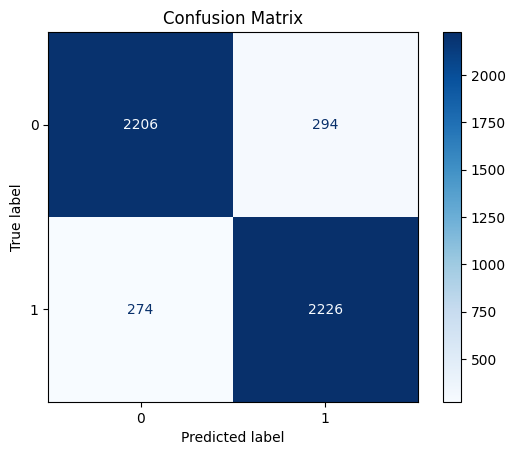

In [ ]:
# Visualize the confusion matrix for our predictions
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the trained model and vectorizer so you can use them later
joblib.dump(model, 'model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')
'Saved'

'Saved'

In [ ]:
# Try out the model: predict sentiment for a custom sentence
def predict_sentiment(text):
    cleaned = clean_text(text)
    X = vectorizer.transform([cleaned])
    pred = model.predict(X)[0]
    if str(pred).strip() == '1':
        return 'Positive'
    else:
        return 'Negative'

user_input = input('Enter a sentence: ')
print('Predicted sentiment:', predict_sentiment(user_input))

Predicted sentiment: Negative
